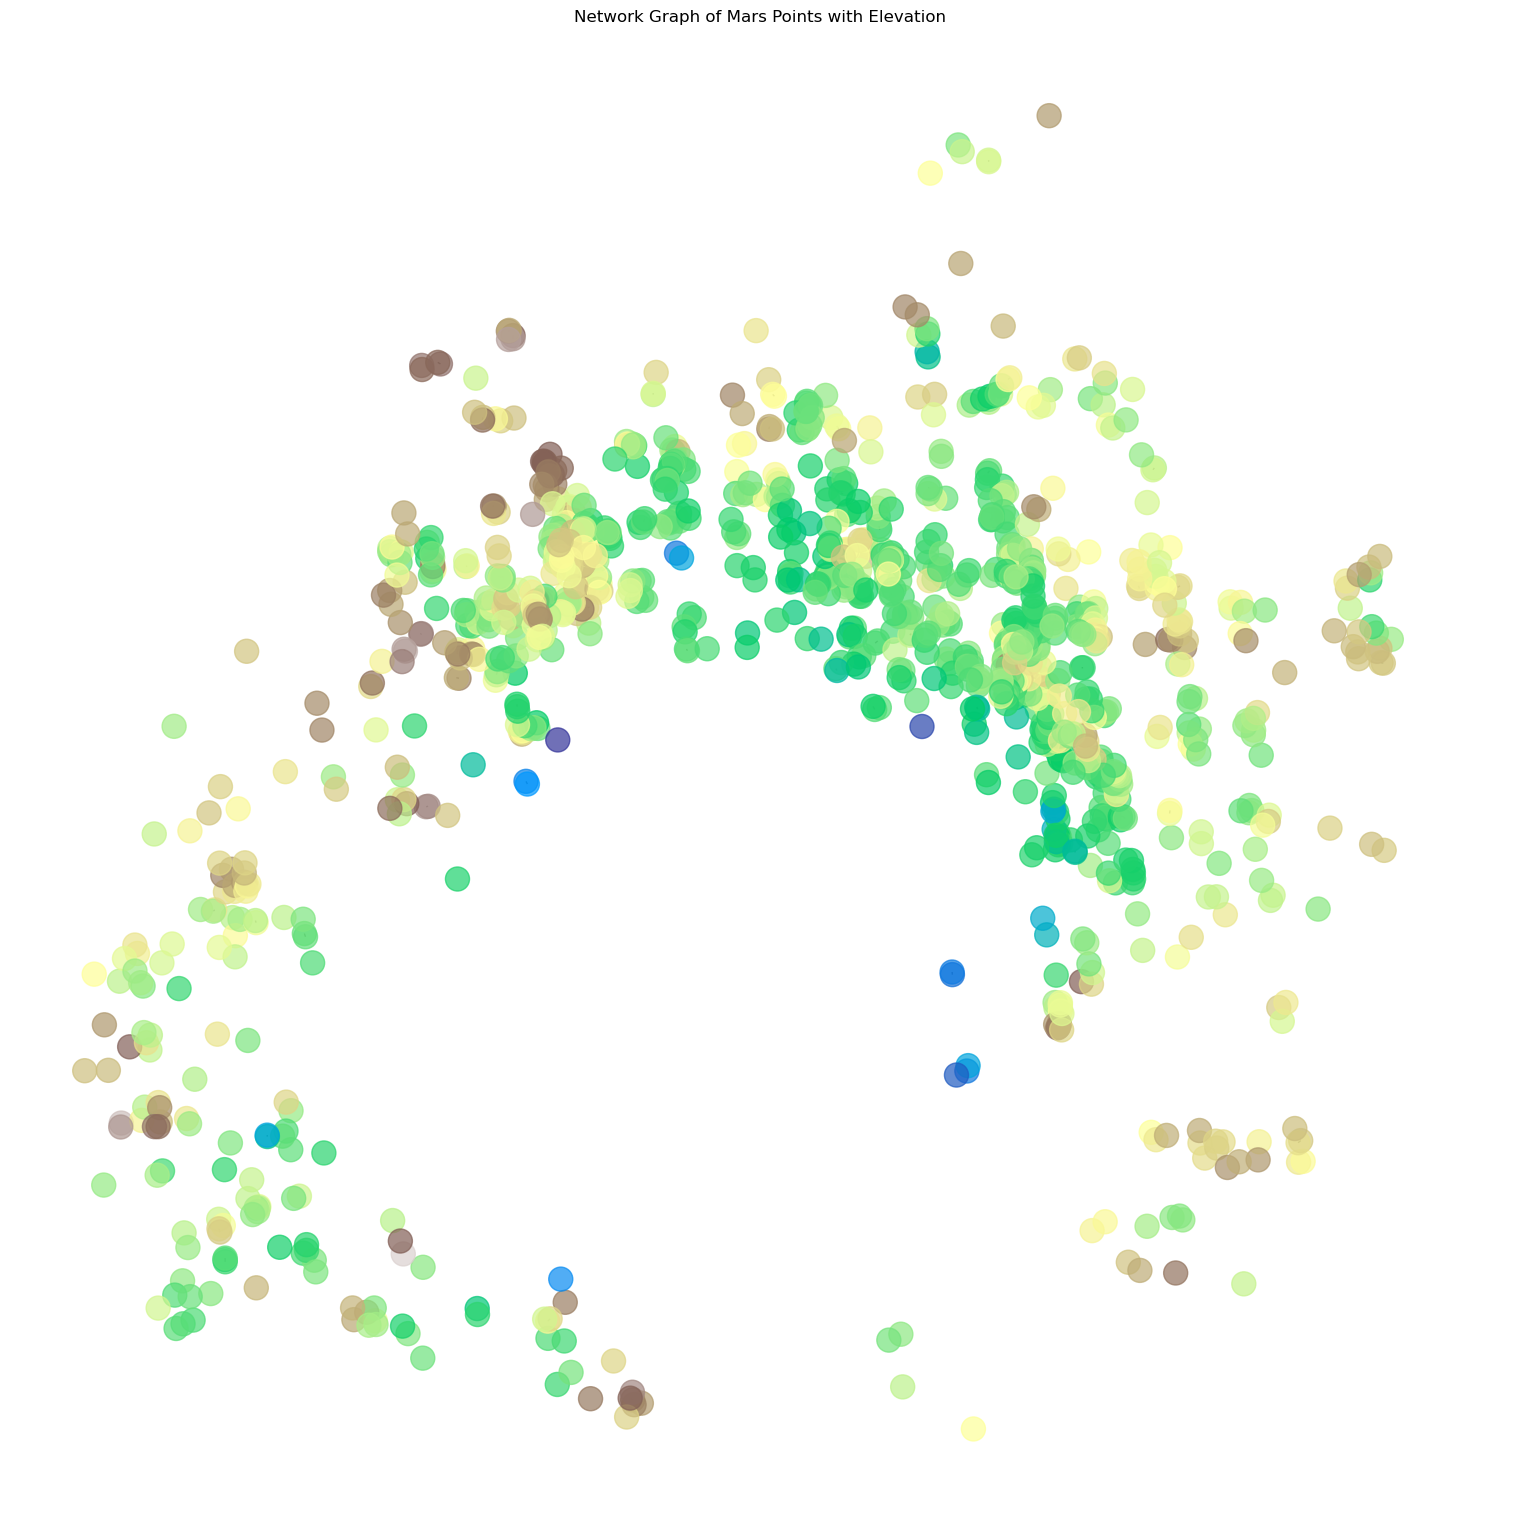

In [1]:
import geopandas as gpd
import numpy as np
import scipy.spatial as spatial
import matplotlib.pyplot as plt
import networkx as nx
import os
from scipy.spatial import distance
import math

# Radius of Mars in kilometers at Argyre (assuming ellipsoid with 3396.19, 3376.2)
R_MARS = 3384.5


def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the distance between two points on Mars (in kilometers)
    given their latitudes and longitudes.

    :param lat1: Latitude of the first point in degrees
    :param lon1: Longitude of the first point in degrees
    :param lat2: Latitude of the second point in degrees
    :param lon2: Longitude of the second point in degrees
    :return: Distance between the two points in kilometers
    """
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = (
        math.sin(dlat / 2) ** 2
        + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    )
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Distance in kilometers
    d = R_MARS * c
    return d


os.environ["PROJ_IGNORE_CELESTIAL_BODY"] = "YES"


def custom_distance(p1, p2):
    lon1, lat1 = p1
    lon2, lat2 = p2
    return round(haversine(lon1, lat1, lon2, lat2), 2)


# Load your GeoPackage file
DATE_STRING = "03062025"
file_path = f"/Users/phillipsm/Documents/Research/MassifMapping/Argyre_QGIS/shape_files/Argyre/all_units_points_argyrePRJ_{DATE_STRING}.gpkg"
gdf = gpd.read_file(file_path)

# Define the categories to keep
categories_of_interest = [
    "type 1 olivine",
    "type 2 olivine",
    "plagioclase",
    "lcp",
    "hcp + olivine",
]
geounits_of_interest = [
    "Argyre basin member 2",
    "Argyre basin member 3",
    "Argyre rim materials",
    "Argyre rim and basin materials",
    "Argye rim and basin materials",
    "Argyre basin and rim materials",
    "Young crater materials",
    "Old crater materials",
]

# Strip leading and trailing spaces from the 'Category' column
gdf["Category"] = gdf["Category"].str.strip()

# Filter the GeoDataFrame to include only the categories of interest
gdf_filtered = gdf[gdf["Category"].isin(categories_of_interest)]
gdf_filtered = gdf_filtered[gdf_filtered["GeoUnits"].isin(geounits_of_interest)]

# Convert the Elevation_km column to meters
gdf_filtered["Elevation_m"] = gdf_filtered["Elevation_km"] * 1000

# Reset the index after filtering
gdf_filtered = gdf_filtered.reset_index(drop=True)

# count the number of each category in the graph
category_counts = gdf_filtered["Category"].value_counts()
total_counts = category_counts.sum()
percent_category_dict = {}
for category, count in category_counts.items():
    percent_category_dict[category] = count / total_counts

# Convert coordinates from degrees to meters (if needed) using an appropriate projection
iau49900 = 'GEOGCS["Mars (2015) - Sphere / Ocentric",DATUM["Mars (2015) - Sphere",SPHEROID["Mars (2015) - Sphere",3396190,0,AUTHORITY["IAU","49900"]],AUTHORITY["IAU","49900"]],PRIMEM["Reference Meridian",0,AUTHORITY["IAU","49900"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["IAU","49900"]]'

gdf_filtered = gdf_filtered.to_crs(iau49900)  # Set to Mars-specific CRS

# Extract coordinates (X, Y) and convert them into a numpy array
coords = np.array([point.coords[0] for point in gdf_filtered.geometry])

# Create a spatial index to efficiently find the nearest neighbors
tree = spatial.cKDTree(coords)

# Set a threshold distance (e.g., 10 km) to connect nearby points
threshold_distance = 5  # in kilometers

# convert threshold distance to degrees
threshold_distance_deg = (threshold_distance / R_MARS) * (180 / math.pi)

dist_matrix = distance.cdist(coords, coords, metric=custom_distance)

# Create an empty graph
G = nx.Graph()

# Add nodes to the graph, incorporate elevation in the position
for idx, row in gdf_filtered.iterrows():
    G.add_node(
        idx,
        label=row["Category"],
        position=(coords[idx][0], coords[idx][1], row["Elevation_m"]),
    )

# Add edges based on proximity (i.e., distance threshold)
for i, point1 in enumerate(coords):
    # Query for all points within the threshold distance
    nearby_points = tree.query_ball_point(point1, threshold_distance_deg)
    for j in nearby_points:
        if i != j:
            G.add_edge(i, j, weight=custom_distance(coords[i], coords[j]))
            G.add_edge(j, i, weight=custom_distance(coords[i], coords[j]))

# # Plot the network graph
# plt.figure(figsize=(15, 15))

# # Get positions for plotting, include elevation in z-axis (3D plot)
# pos = {node: (G.nodes[node]['position'][0], G.nodes[node]['position'][1]) for node in G.nodes}

# # Draw the network graph with the elevation influencing node size or color
# node_sizes = [G.nodes[node]['position'][2] / 100 for node in G.nodes]  # Scale node size by elevation
# node_colors = [G.nodes[node]['position'][2] for node in G.nodes]  # Use elevation for color

# # Draw the network graph
# nx.draw(G, pos, with_labels=True, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.viridis, font_size=8, font_weight='bold', alpha=0.7)

# plt.title("Network Graph of Mars Points with Elevation")
# plt.colorbar(label='Elevation (m)')  # Color bar for elevation
# plt.show()

import matplotlib.cm as cm
import matplotlib.colors as mcolors

# Draw the network graph with the elevation influencing node size or color
node_sizes = [
    G.nodes[node]["position"][2] / 50 for node in G.nodes
]  # Scale node size by elevation
node_colors = [
    G.nodes[node]["position"][2] for node in G.nodes
]  # Use elevation for color

# Create a colormap and normalize elevation values
norm = mcolors.Normalize(vmin=min(node_colors), vmax=max(node_colors))
cmap = cm.terrain

# Create a ScalarMappable object for color mapping
sm = cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # This is needed to avoid warning messages

# Plot the network graph
plt.figure(figsize=(15, 15))

# Get positions for plotting, include elevation in z-axis (3D plot)
pos = {
    node: (G.nodes[node]["position"][0], G.nodes[node]["position"][1])
    for node in G.nodes
}

# Draw the network graph with the elevation influencing node size or color
# node_sizes = [G.nodes[node]['position'][2] / 100 for node in G.nodes]  # Scale node size by elevation
# node_colors = [G.nodes[node]['position'][2] for node in G.nodes]  # Use elevation for color

# Draw the network graph
nx.draw(
    G,
    pos,
    with_labels=False,
    node_color=node_colors,
    cmap=plt.cm.terrain,
    font_size=8,
    font_weight="bold",
    alpha=0.7,
)

# Add a color bar using the ScalarMappable object
# plt.colorbar(sm, label='Elevation (m)')

plt.title("Network Graph of Mars Points with Elevation")
plt.show()

In [2]:
import numpy as np
import pandas as pd

# Create a list to store the relative elevation differences with categories
elevation_diff_data = []

# Iterate through all edges in the graph
for node1, node2 in G.edges():
    # Get the elevation values for the two nodes
    elevation_node1 = G.nodes[node1]["position"][
        2
    ]  # z-coordinate is the elevation (in meters)
    elevation_node2 = G.nodes[node2]["position"][2]

    # Get the categories of the nodes
    category_node1 = gdf_filtered.loc[node1, "Category"]
    category_node2 = gdf_filtered.loc[node2, "Category"]

    # Get the pn of the nodes
    pn_node1 = gdf_filtered.loc[node1, "Polygon Number"]
    pn_node2 = gdf_filtered.loc[node2, "Polygon Number"]

    # Get the pn of the nodes
    tn_node1 = gdf_filtered.loc[node1, "Source File"]
    tn_node2 = gdf_filtered.loc[node2, "Source File"]

    # Calculate the distance between the two nodes (already in kilometers)
    distance_km = G[node1][node2]["weight"]

    # Check if the nodes are within the threshold distance (10 km)
    if distance_km <= 10:
        # Calculate the relative elevation difference
        elevation_diff = elevation_node1 - elevation_node2

        # Store the data including categories
        elevation_diff_data.append(
            {
                "node1": node1,
                "node2": node2,
                "distance_km": distance_km,
                "category_node1": category_node1,
                "category_node2": category_node2,
                "elevation_node1": elevation_node1,
                "elevation_node2": elevation_node2,
                "elevation_diff": elevation_diff,
                "pn_node1": pn_node1,
                "pn_node2": pn_node2,
                "tn_node1": tn_node1,
                "tn_node2": tn_node2,
            }
        )

# Convert the data into a DataFrame for easier analysis
elevation_diff_df = pd.DataFrame(elevation_diff_data)

# Display basic statistics about the relative elevation differences
elevation_diff_stats = elevation_diff_df.describe()

# Display the DataFrame with the elevation differences and statistics
elevation_diff_df.head(), elevation_diff_stats

# # optionally save
# elevation_diff_df.to_excel('elevation_diff_data.xlsx')

(   node1  node2  distance_km  category_node1  category_node2  elevation_node1  \
 0      8      9         4.06  type 2 olivine   hcp + olivine       169.085106   
 1     17     18         2.90  type 2 olivine  type 2 olivine      -234.344828   
 2     18     19         3.71  type 2 olivine  type 2 olivine      -541.957295   
 3     20     23         2.73             lcp             lcp     -1076.194030   
 4     25     26         3.31  type 1 olivine             lcp       203.464286   
 
    elevation_node2  elevation_diff pn_node1 pn_node2 tn_node1 tn_node2  
 0       103.923077       65.162029       18       20    T0507    T0507  
 1      -541.957295      307.612468       46       48    T0507    T0507  
 2     -1351.631429      809.674133       48       50    T0507    T0507  
 3      -878.681818     -197.512212       52       60    T0507    T0507  
 4       349.282609     -145.818323       64       66    T0507    T0507  ,
              node1        node2  distance_km  elevation_node

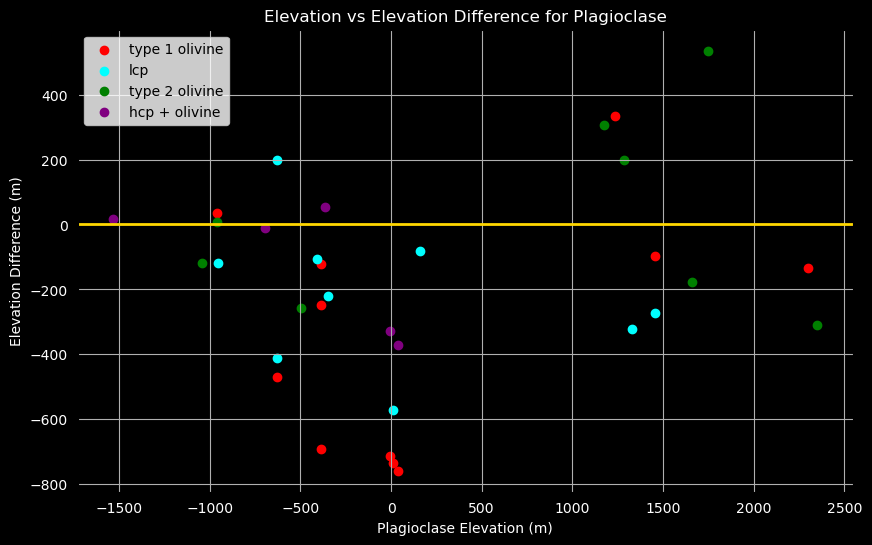

In [3]:
import matplotlib.pyplot as plt

# Filter the DataFrame for category_node1 equal to 'Plagioclase'
plagioclase_data = elevation_diff_df[
    elevation_diff_df["category_node1"] == "plagioclase"
]

# Get unique categories from category_node2 for color-coding
categories = plagioclase_data["category_node2"].unique()
colors = [
    "red",
    "cyan",
    "gold",
    "green",
    "purple",
]  # plt.cm.tab10.colors  # Choose a colormap for colors

plt.figure(figsize=(10, 6))
plt.axhline(y=0, color="gold", linewidth=2)  # Add a horizontal line at y=0
for i, category in enumerate(categories):
    if category == "plagioclase":
        continue
    category_data = plagioclase_data[plagioclase_data["category_node2"] == category]
    plt.scatter(
        category_data["elevation_node1"],
        -category_data["elevation_diff"],
        color=colors[i],
        label=category,
    )

plt.gca().set_facecolor("black")  # Axes background color
plt.gcf().set_facecolor("black")  # Figure background color
plt.title("Elevation vs Elevation Difference for Plagioclase", color="white")
plt.xlabel("Plagioclase Elevation (m)", color="white")
plt.ylabel("Elevation Difference (m)", color="white")
plt.legend()
plt.xticks(color="white")
plt.yticks(color="white")
plt.grid(True)
plt.show()

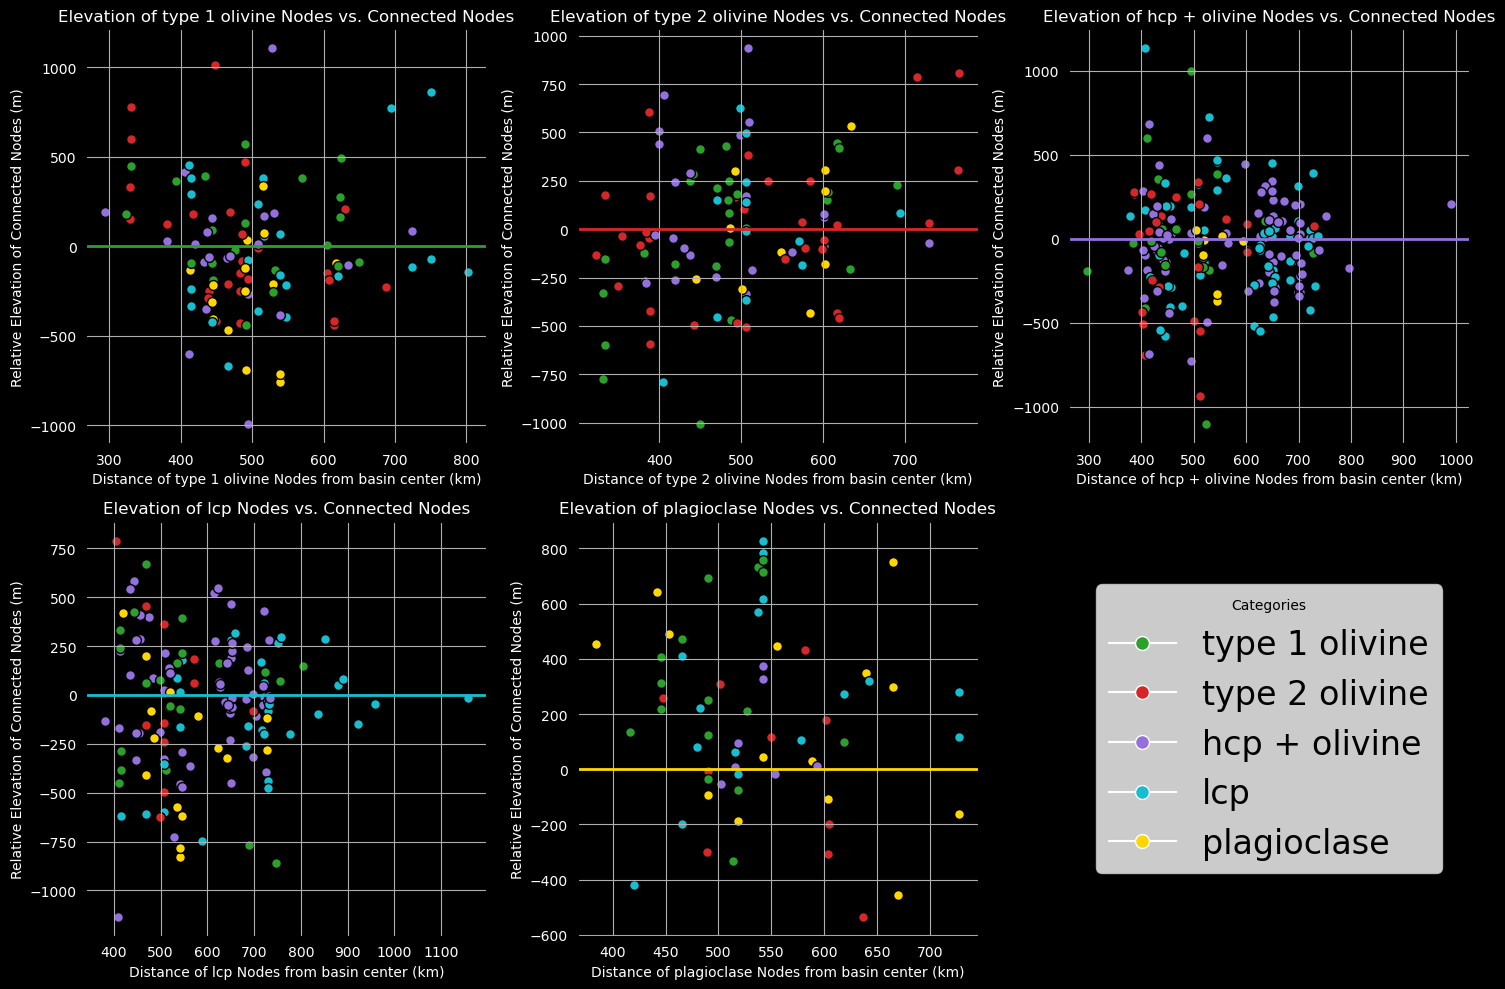

In [9]:
import matplotlib.pyplot as plt

category_colors = {
    "type 1 olivine": "tab:green",
    "type 2 olivine": "tab:red",
    "hcp + olivine": "mediumpurple",
    "lcp": "tab:cyan",
    "plagioclase": "gold",
}
connected_elevations_dict = {}

# fig, ax = plt.figure(figsize=(10, 6))
fig, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(15, 10))
axs = [ax1, ax2, ax3, ax4, ax5]
for ref_cat, ax in zip(category_colors.keys(), axs):
    plt.sca(ax)
    # Create lists to store data for the plot
    plagioclase_distances = []
    plagioclase_elevations = []
    connected_elevations = []
    connected_categories = []
    # Iterate through all edges in the graph
    for node1, node2 in G.edges():
        # Get the category of node1 (the source node)
        category_node1 = gdf_filtered.loc[node1, "Category"]
        category_node2 = gdf_filtered.loc[node2, "Category"]

        if category_node1 == ref_cat:
            # Get the elevation of node1
            distance_node1 = gdf_filtered.loc[node1, "Distance_to_center_km"]
            elevation_node1 = G.nodes[node1]["position"][2]

            # Get the elevation of node2 (connected node)
            elevation_node2 = G.nodes[node2]["position"][2]

            # Append the data for plotting
            plagioclase_distances.append(distance_node1)
            plagioclase_elevations.append(elevation_node1)
            connected_elevations.append(elevation_node1 - elevation_node2)
            connected_categories.append(category_node2)
        elif category_node2 == ref_cat:
            # Get the elevation of node2
            distance_node2 = gdf_filtered.loc[node2, "Distance_to_center_km"]
            elevation_node2 = G.nodes[node2]["position"][2]

            # Get the elevation node1 (connected node)
            elevation_node1 = G.nodes[node1]["position"][2]

            # Append the data for plotting
            plagioclase_distances.append(distance_node2)
            plagioclase_elevations.append(elevation_node2)
            connected_elevations.append(elevation_node2 - elevation_node1)
            connected_categories.append(category_node1)
    connected_elevations_dict[ref_cat] = connected_elevations
    # Now plot the data with category-specific colors
    plt.axhline(
        y=0, color=category_colors[ref_cat], linewidth=2
    )  # Add a horizontal line at y=0
    # Loop through the connected categories and assign the appropriate color
    for i, category in enumerate(connected_categories):
        # if category == 'plagioclase':
        #     continue
        color = category_colors.get(
            category, "gray"
        )  # Default to gray if category is not in the dictionary
        plt.scatter(
            plagioclase_distances[i],
            connected_elevations[i],
            color=color,
            edgecolors="black",
            s=50,
        )

    plt.gca().set_facecolor("black")  # Axes background color
    plt.gcf().set_facecolor("black")  # Figure background color
    # Set plot labels and title
    plt.title(f"Elevation of {ref_cat} Nodes vs. Connected Nodes", color="white")
    plt.xlabel(f"Distance of {ref_cat} Nodes from basin center (km)", color="white")
    plt.ylabel("Relative Elevation of Connected Nodes (m)", color="white")
    plt.grid(True)
    plt.xticks(color="white")
    plt.yticks(color="white")

    # Add a legend
    handles = [
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            markerfacecolor=color,
            markersize=10,
            label=category,
        )
        for category, color in category_colors.items()
    ]
plt.sca(ax6)
plt.gca().set_facecolor("black")  # Axes background color
plt.gcf().set_facecolor("black")  # Figure background color
# plt.legend(handles=handles, title="Categories", loc='center')#, bbox_to_anchor=(1, 1))
plt.legend(handles=handles, title="Categories", loc="center", prop={"size": 24})
# Show the plot
plt.tight_layout()
plt.show()

# plt.figure(figsize=(10, 6))
# plt.axhline(y=0, color='gold', linewidth=2)  # Add a horizontal line at y=0
# # Loop through the connected categories and assign the appropriate color
# for i, category in enumerate(connected_categories):
#     # if category == 'plagioclase':
#     #     continue
#     color = category_colors.get(category, 'gray')  # Default to gray if category is not in the dictionary
#     plt.scatter(plagioclase_elevations[i], connected_elevations[i],
#                 color=color, edgecolors='black', s=50)

# plt.gca().set_facecolor('black')  # Axes background color
# plt.gcf().set_facecolor('black')  # Figure background color
# # Set plot labels and title
# plt.title('Elevation of Plagioclase Nodes vs. Connected Nodes', color='white')
# plt.xlabel('Elevation of Plagioclase Nodes (m)', color='white')
# plt.ylabel('Relative Elevation of Connected Nodes (m)', color='white')
# plt.grid(True)
# plt.xticks(color='white')
# plt.yticks(color='white')

# # Add a legend
# handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10, label=category)
#            for category, color in category_colors.items()]
# plt.legend(handles=handles, title="Categories", loc='upper left', bbox_to_anchor=(1, 1))

# # Show the plot
# plt.show()

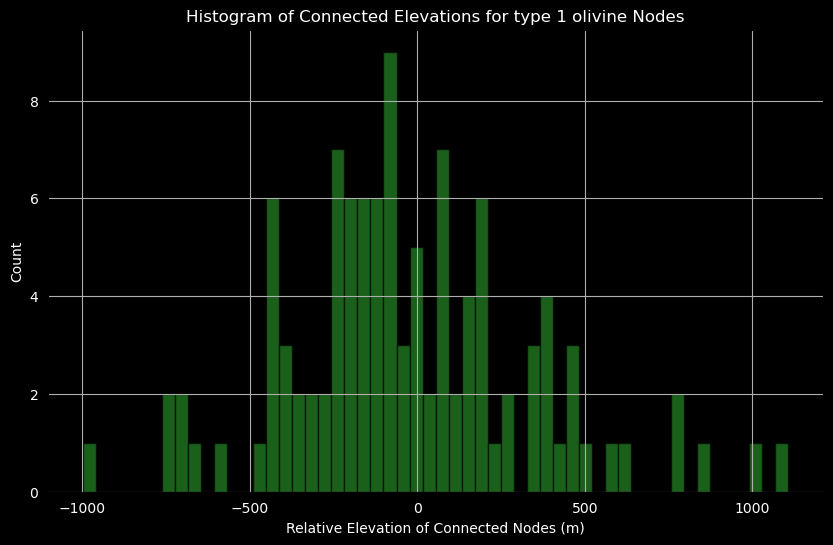

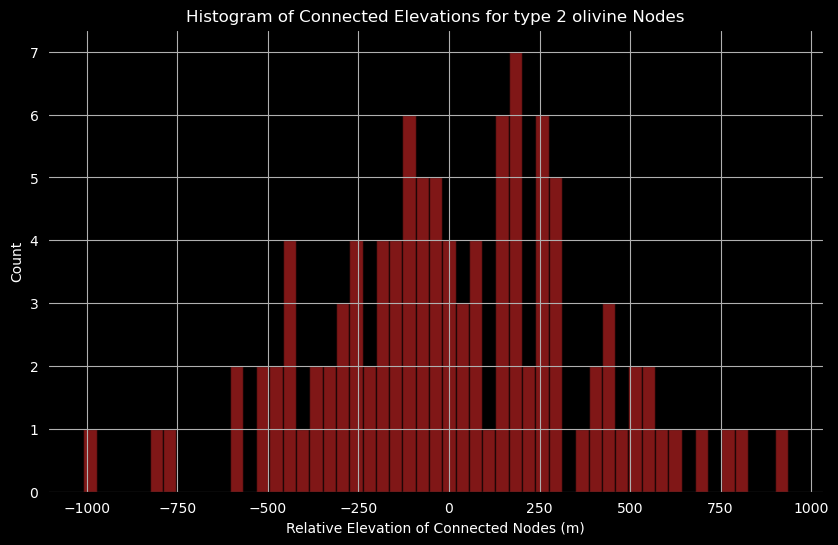

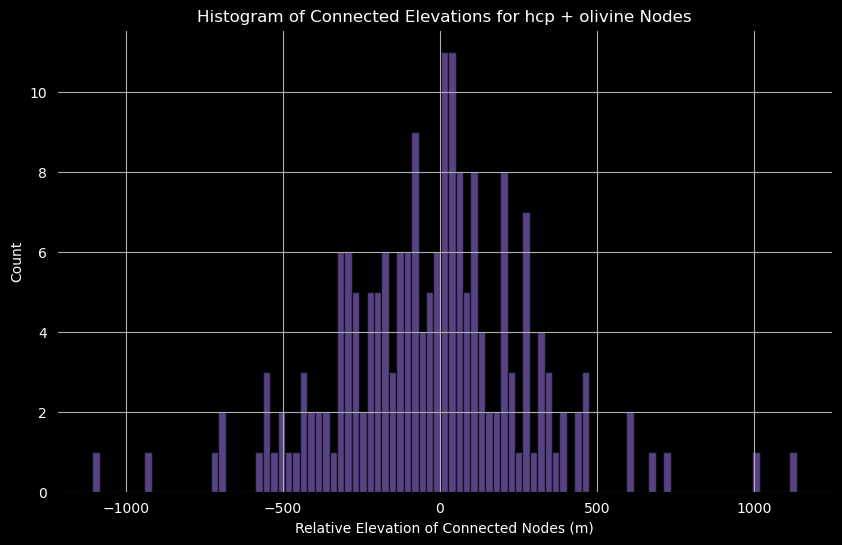

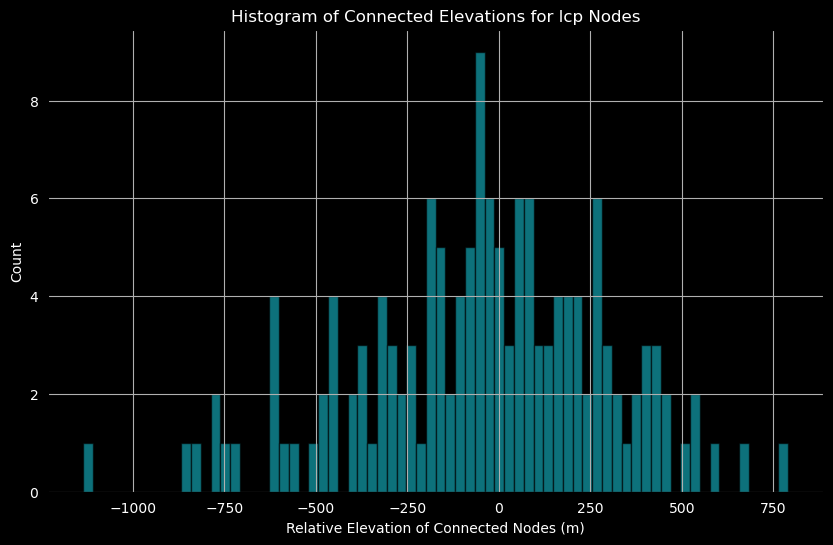

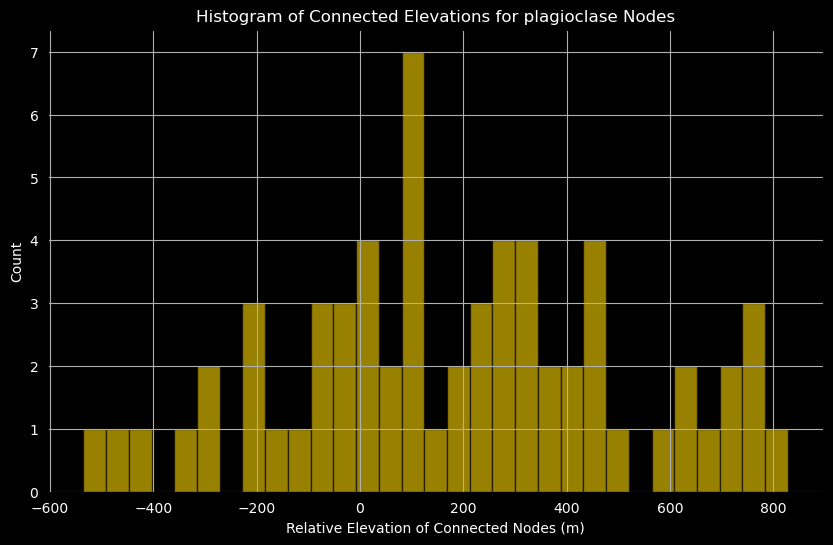

In [10]:
# plot histograms of connected elevations in connected_elevations_dict

for category, elevations in connected_elevations_dict.items():
    plt.figure(figsize=(10, 6))
    plt.hist(
        elevations,
        bins=int(len(elevations) / 2),
        color=category_colors[category],
        alpha=0.6,
        edgecolor="black",
    )
    plt.gca().set_facecolor("black")  # Axes background color
    plt.gcf().set_facecolor("black")  # Figure background color
    # Set plot labels and title
    plt.title(f"Histogram of Connected Elevations for {category} Nodes", color="white")
    plt.xlabel("Relative Elevation of Connected Nodes (m)", color="white")
    plt.ylabel("Count", color="white")
    plt.grid(True)
    plt.xticks(color="white")
    plt.yticks(color="white")
    plt.show()

In [6]:
connected_elevations_dict

{'type 1 olivine': [145.81832298136646,
  133.1270928462709,
  135.07085561497328,
  210.91849529780558,
  -69.85982905982905,
  395.63379310344817,
  216.37517241379305,
  734.4100930916218,
  163.52747252747247,
  -185.13181214000886,
  364.8228571428571,
  8.23555555555555,
  -233.15870967741935,
  431.89663461538464,
  -36.25357142857149,
  85.44888888888886,
  250.46497584541066,
  -67.69000000000005,
  152.6889901823282,
  470.96190476190475,
  60.44603174603162,
  668.7,
  212.4708333333333,
  65.69694370809293,
  105.96695226438187,
  -207.01688596491226,
  96.86226851851848,
  79.05320512820504,
  758.426282051282,
  713.051282051282,
  385.8131868131868,
  269.19999999999993,
  996.2347826086956,
  183.0823529411764,
  249.49378881987582,
  122.26190476190476,
  691.4285714285714,
  -127.23188405797106,
  -569.1666666666667,
  441.9347826086956,
  -472.0886287625418,
  20.708166761850407,
  248.71422851863258,
  -382.2637770897833,
  287.1658064158063,
  -389.5648148148148,
 

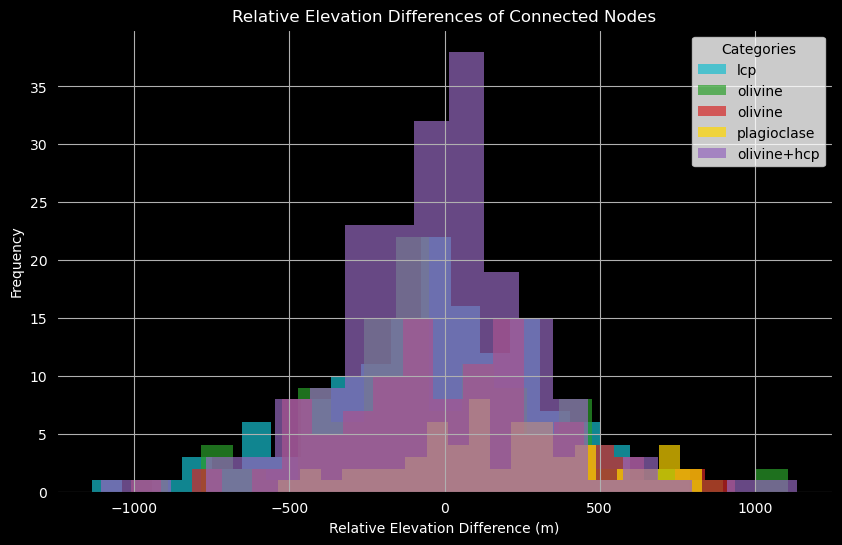

In [11]:
# make a histogram of the relative elevation differences
fig, ax = plt.subplots(figsize=(10, 6))
# plt.hist(connected_elevations_dict['hcp'], bins=20, color='magenta', alpha=0.7, label='hcp')
plt.hist(
    connected_elevations_dict["lcp"], bins=20, color="tab:cyan", alpha=0.7, label="lcp"
)
plt.hist(
    connected_elevations_dict["type 1 olivine"],
    bins=20,
    color="tab:green",
    alpha=0.7,
    label="olivine",
)
plt.hist(
    connected_elevations_dict["type 2 olivine"],
    bins=20,
    color="tab:red",
    alpha=0.7,
    label="olivine",
)
plt.hist(
    connected_elevations_dict["plagioclase"],
    bins=20,
    color="gold",
    alpha=0.7,
    label="plagioclase",
)
plt.hist(
    connected_elevations_dict["hcp + olivine"],
    bins=20,
    color="tab:purple",
    alpha=0.7,
    label="olivine+hcp",
)
plt.gca().set_facecolor("black")  # Axes background color
plt.gcf().set_facecolor("black")  # Figure background color
plt.title("Relative Elevation Differences of Connected Nodes", color="white")
plt.xlabel("Relative Elevation Difference (m)", color="white")
plt.ylabel("Frequency", color="white")
plt.grid(True)
plt.xticks(color="white")
plt.yticks(color="white")
plt.legend(title="Categories", loc="upper right")
plt.show()

6.163473631000407 7.265127511416895e-05


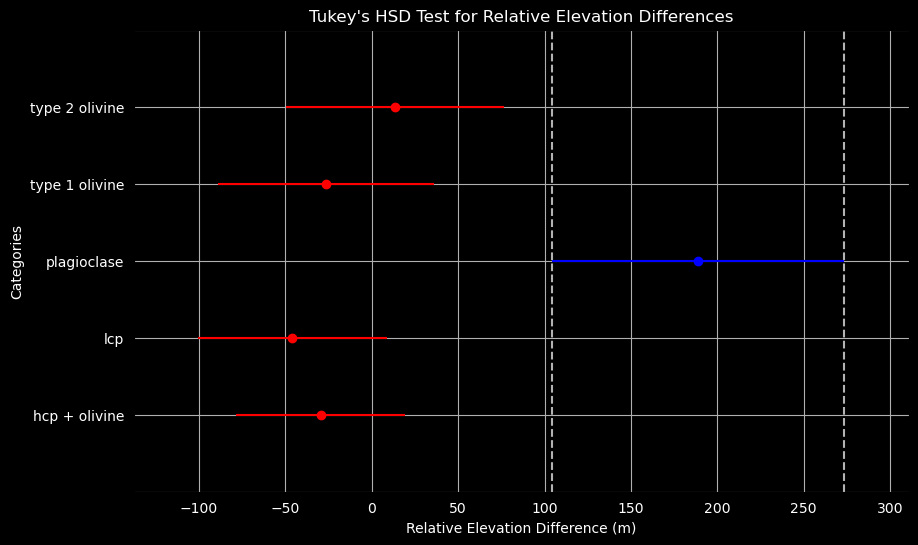

In [12]:
# run an anova to see if the relative elevation differences are significantly different
import scipy.stats as stats

# Perform one-way ANOVA
# first, remove any NaN values
connected_elevations_dict = {
    key: [val for val in connected_elevations if not np.isnan(val)]
    for key, connected_elevations in connected_elevations_dict.items()
}
f_stat, p_value = stats.f_oneway(
    connected_elevations_dict["hcp + olivine"],
    connected_elevations_dict["lcp"],
    connected_elevations_dict["type 1 olivine"],
    connected_elevations_dict["plagioclase"],
    connected_elevations_dict["type 2 olivine"],
)

# Display the F-statistic and p-value
print(f_stat, p_value)

# perform a multiple comparison test
from statsmodels.stats.multicomp import pairwise_tukeyhsd

# Combine all the data into a single array
all_data = np.concatenate(
    [
        connected_elevations_dict["hcp + olivine"],
        connected_elevations_dict["lcp"],
        connected_elevations_dict["type 1 olivine"],
        connected_elevations_dict["plagioclase"],
        connected_elevations_dict["type 2 olivine"],
    ]
)
# Create labels for the groups
group_labels = (
    ["hcp + olivine"] * len(connected_elevations_dict["hcp + olivine"])
    + ["lcp"] * len(connected_elevations_dict["lcp"])
    + ["type 1 olivine"] * len(connected_elevations_dict["type 1 olivine"])
    + ["plagioclase"] * len(connected_elevations_dict["plagioclase"])
    + ["type 2 olivine"] * len(connected_elevations_dict["type 2 olivine"])
)

# Perform Tukey's HSD test
tukey_results = pairwise_tukeyhsd(all_data, group_labels, alpha=0.05)

# Display the results of the Tukey's HSD test
tukey_results.summary()

# Plot the results of the Tukey's HSD test
fig, ax = plt.subplots(figsize=(10, 6))
tukey_results.plot_simultaneous(comparison_name="plagioclase", ax=ax)
plt.gca().set_facecolor("black")  # Axes background color
plt.gcf().set_facecolor("black")  # Figure background color
plt.title("Tukey's HSD Test for Relative Elevation Differences", color="white")
plt.xlabel("Relative Elevation Difference (m)", color="white")
plt.ylabel("Categories", color="white")
plt.grid(True)
plt.xticks(color="white")
plt.yticks(color="white")
plt.show()

# older stuff

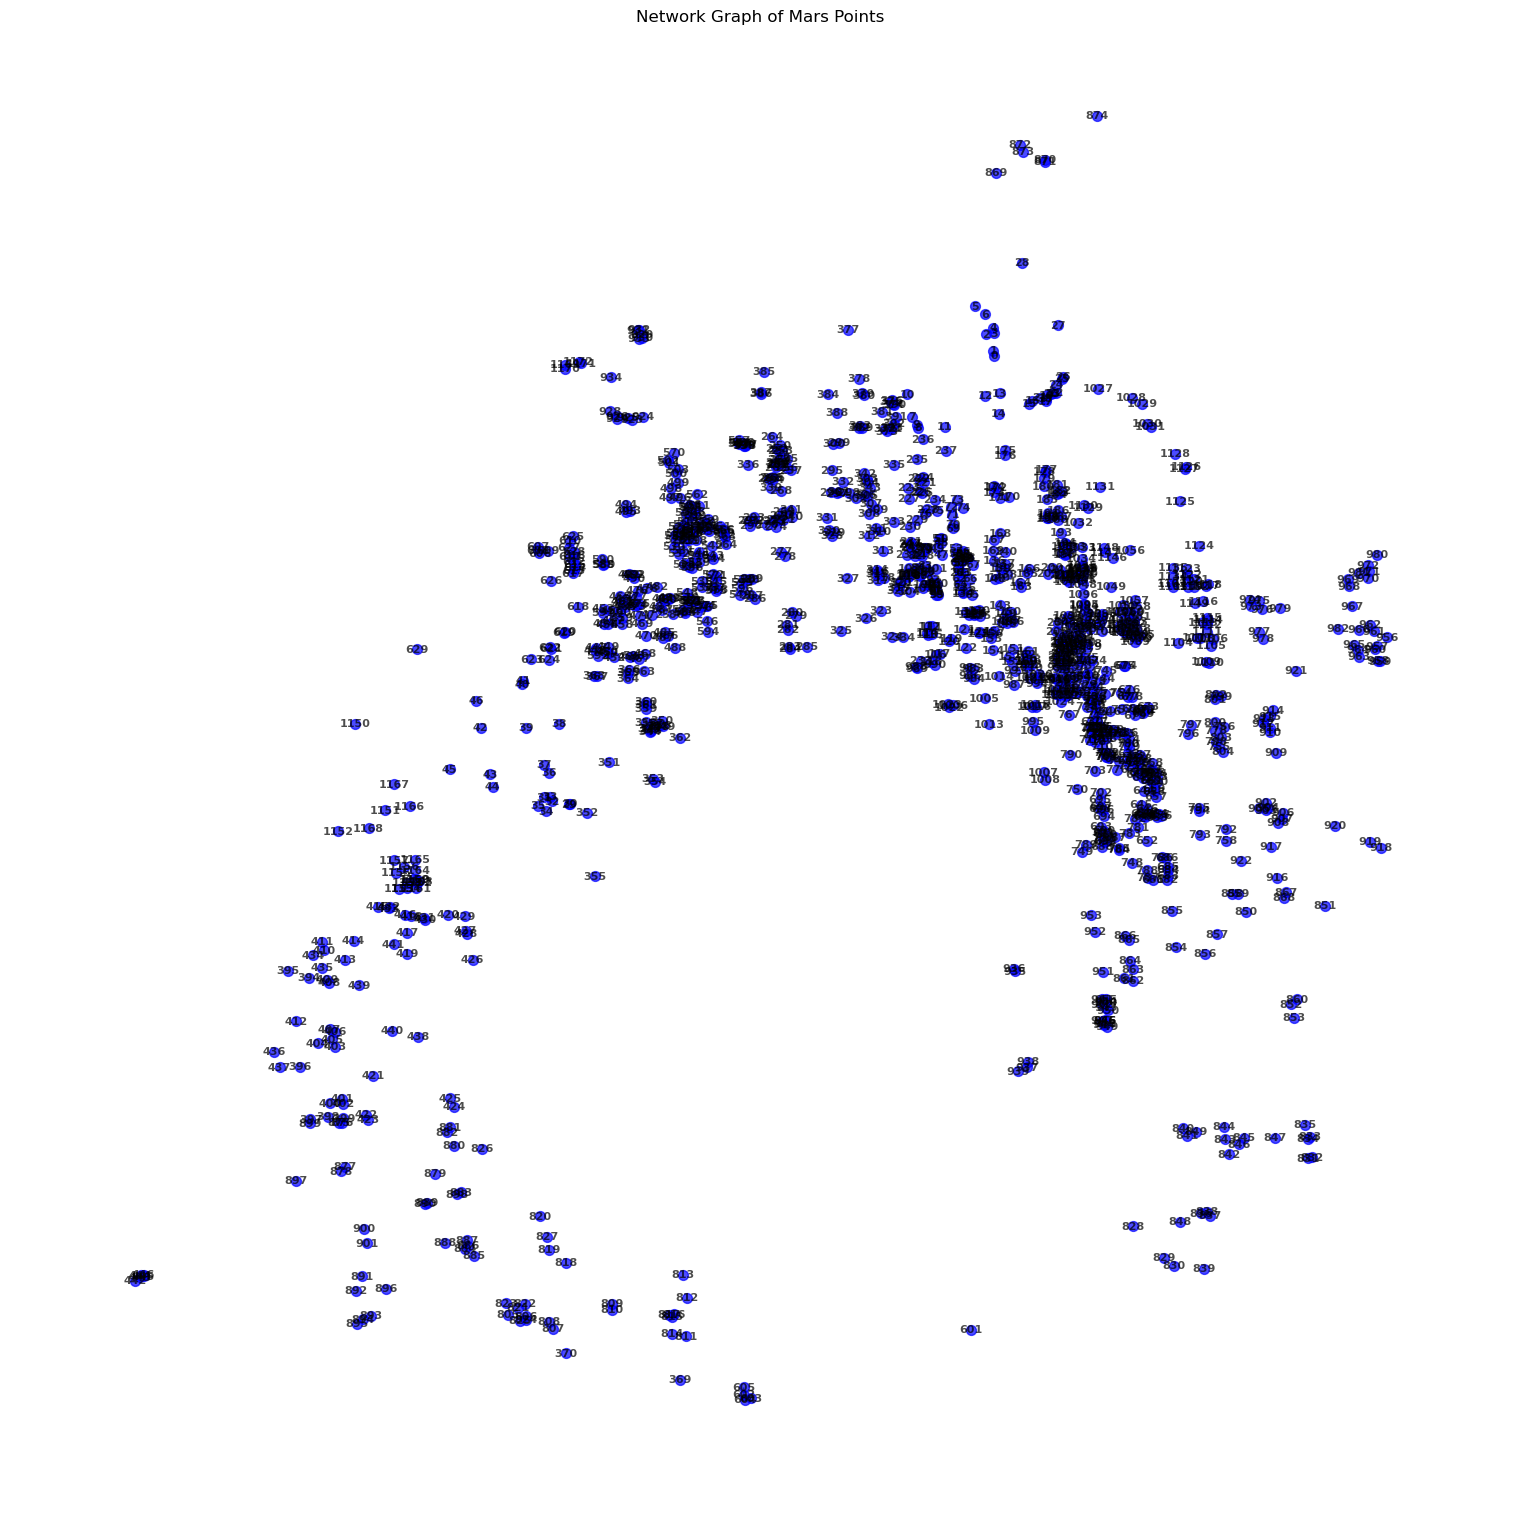

In [1]:
import geopandas as gpd
import numpy as np
import scipy.spatial as spatial
import matplotlib.pyplot as plt
import networkx as nx
import os
from scipy.spatial import distance
import math

# Radius of Mars in kilometers at Argyre (assuming ellipsoid with 3396.19, 3376.2)
R_MARS = 3384.5


def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the distance between two points on Mars (in kilometers)
    given their latitudes and longitudes.

    :param lat1: Latitude of the first point in degrees
    :param lon1: Longitude of the first point in degrees
    :param lat2: Latitude of the second point in degrees
    :param lon2: Longitude of the second point in degrees
    :return: Distance between the two points in kilometers
    """
    # Convert latitude and longitude from degrees to radians
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])

    # Haversine formula
    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = (
        math.sin(dlat / 2) ** 2
        + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2) ** 2
    )
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    # Distance in kilometers
    d = R_MARS * c
    return d


os.environ["PROJ_IGNORE_CELESTIAL_BODY"] = "YES"


def custom_distance(p1, p2):
    lon1, lat1 = p1
    lon2, lat2 = p2
    return round(haversine(lon1, lat1, lon2, lat2), 2)


# Load your GeoPackage file
DATE_STRING = "11182024"
file_path = f"/Users/phillipsm/Documents/Research/MassifMapping/Argyre_QGIS/shape_files/Argyre/all_units_points_argyrePRJ_{DATE_STRING}.gpkg"
gdf = gpd.read_file(file_path)

# Define the categories to keep
categories_of_interest = [
    "type 1 olivine",
    "type 2 olivine",
    "plagioclase",
    "lcp",
    "hcp + olivine",
]
geounits_of_interest = [
    "Argyre basin member 2",
    "Argyre basin member 3",
    "Argyre rim materials",
    "Argyre rim and basin materials",
    "Argye rim and basin materials",
    "Argyre basin and rim materials",
    "Young crater materials",
    "Old crater materials",
]

# Strip leading and trailing spaces from the 'Category' column
gdf["Category"] = gdf["Category"].str.strip()

# Filter the GeoDataFrame to include only the categories of interest
gdf_filtered = gdf[gdf["Category"].isin(categories_of_interest)]
gdf_filtered = gdf_filtered[gdf_filtered["GeoUnits"].isin(geounits_of_interest)]

# Convert the Elevation_km column to meters
gdf_filtered["Elevation_m"] = gdf_filtered["Elevation_km"] * 1000

# Reset the index after filtering
gdf_filtered = gdf_filtered.reset_index(drop=True)

# count the number of each category in the graph
category_counts = gdf_filtered["Category"].value_counts()
total_counts = category_counts.sum()
percent_category_dict = {}
for category, count in category_counts.items():
    percent_category_dict[category] = count / total_counts

# Convert coordinates from degrees to meters (if needed) using an appropriate projection
iau49900 = 'GEOGCS["Mars (2015) - Sphere / Ocentric",DATUM["Mars (2015) - Sphere",SPHEROID["Mars (2015) - Sphere",3396190,0,AUTHORITY["IAU","49900"]],AUTHORITY["IAU","49900"]],PRIMEM["Reference Meridian",0,AUTHORITY["IAU","49900"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["IAU","49900"]]'

gdf_filtered = gdf_filtered.to_crs(iau49900)  # Set to Mars-specific CRS

# Extract coordinates (X, Y) and convert them into a numpy array
coords = np.array([point.coords[0] for point in gdf_filtered.geometry])

# Create a spatial index to efficiently find the nearest neighbors
tree = spatial.cKDTree(coords)

# Set a threshold distance (e.g., 10 km) to connect nearby points
threshold_distance = 10  # in kilometers

# convert threshold distance to degrees
threshold_distance_deg = (threshold_distance / R_MARS) * (180 / math.pi)

dist_matrix = distance.cdist(coords, coords, metric=custom_distance)
# nearby_points = np.where(dist_matrix[0] <= threshold_distance)[0]

# Create an empty graph
G = nx.Graph()

# Add nodes to the graph
for idx, row in gdf_filtered.iterrows():
    G.add_node(idx, label=row["Category"], position=coords[idx])

# Add edges based on proximity (i.e., distance threshold)
for i, point1 in enumerate(coords):
    # Query for all points within the threshold distance
    nearby_points = tree.query_ball_point(point1, threshold_distance_deg)
    for j in nearby_points:
        if i != j:
            G.add_edge(i, j, weight=custom_distance(coords[i], coords[j]))

# Plot the network graph
plt.figure(figsize=(15, 15))

# Get positions for plotting
pos = {
    node: (G.nodes[node]["position"][0], G.nodes[node]["position"][1])
    for node in G.nodes
}

# Draw the network graph
nx.draw(
    G,
    pos,
    with_labels=True,
    node_size=50,
    node_color="blue",
    font_size=8,
    font_weight="bold",
    alpha=0.7,
)

plt.title("Network Graph of Mars Points")
plt.show()

In [15]:
import pandas as pd


def calculate_avg_distance_by_category(G):
    # Store results in a list of dictionaries for DataFrame creation
    data = []

    # Go through each node
    for node in G.nodes():
        node_category = G.nodes[node]["label"]
        neighbors = G.neighbors(node)

        # Dictionary to store sum of distances and counts by category
        category_distances = {}

        for neighbor in neighbors:
            neighbor_category = G.nodes[neighbor]["label"]
            distance = G.edges[node, neighbor]["weight"]

            # Accumulate distances by category
            if neighbor_category not in category_distances:
                category_distances[neighbor_category] = {"sum_distance": 0, "count": 0}

            category_distances[neighbor_category]["sum_distance"] += distance
            category_distances[neighbor_category]["count"] += 1

        # Calculate average distances by category
        for category, values in category_distances.items():
            avg_distance = values["sum_distance"] / values["count"]
            data.append(
                {
                    "Node": node,
                    "Node Category": node_category,
                    "Neighbor Category": category,
                    "Average Distance": avg_distance,
                    "Number of Neighbors": values["count"],
                }
            )

    # Convert to DataFrame
    df = pd.DataFrame(data)
    return df


# Step 2: Calculate average distances by category
avg_dist_df = calculate_avg_distance_by_category(G)

# Assuming 'df' is your original DataFrame
# Pivot the DataFrame to create columns for each Neighbor Category
pivot_df = avg_dist_df.pivot_table(
    index=["Node", "Node Category"],  # Keep each node and its category as unique rows
    columns="Neighbor Category",  # Each neighbor category becomes a column
    values="Average Distance",  # Fill values with average distances
    aggfunc="mean",  # In case of duplicates, take the first occurrence
).reset_index()

pivot_df2 = avg_dist_df.pivot_table(
    index=["Node", "Node Category"],  # Keep each node and its category as unique rows
    columns="Neighbor Category",  # Each neighbor category becomes a column
    values="Number of Neighbors",  # Fill values with average distances
    aggfunc="mean",  # In case of duplicates, take the first occurrence
).reset_index()

# Rename columns to be more descriptive
pivot_df.columns.name = None  # Remove the column index name
pivot_df = pivot_df.rename(
    columns=lambda x: f"Average Distance to {x}" if x in categories_of_interest else x
)
summary_df = pivot_df.groupby("Node Category").mean().reset_index()
summary_df2 = pivot_df2.groupby("Node Category").mean().reset_index()

# pivot_df.to_excel('avg_distance_by_category.xlsx', index=False)
# summary_df.to_excel('avg_distance_by_category_summary2.xlsx', index=False)
# summary_df2.to_excel('avg_distance_by_category_summary2.2.xlsx', index=False)

In [16]:
summary_df2

Neighbor Category,Node Category,Node,hcp + olivine,lcp,plagioclase,type 1 olivine,type 2 olivine
0,hcp + olivine,627.774194,2.175732,1.304348,1.466667,1.000000,1.354839
1,lcp,642.265537,1.818182,1.410714,1.583333,1.000000,1.465517
2,plagioclase,401.417910,1.222222,1.727273,1.434783,1.000000,1.785714
3,type 1 olivine,570.714286,1.333333,2.000000,1.000000,1.666667,1.700000
4,type 2 olivine,515.586066,1.326316,1.465517,1.428571,1.000000,1.871345


In [17]:
summary_df

,Node Category,Node,Average Distance to hcp + olivine,Average Distance to lcp,Average Distance to plagioclase,Average Distance to type 1 olivine,Average Distance to type 2 olivine
0,hcp + olivine,627.774194,5.802708,5.196174,6.414333,6.332500,6.006156
1,lcp,642.265537,5.153528,5.694568,5.502847,5.468750,5.887500
2,plagioclase,401.417910,6.001296,5.490508,5.365109,1.280000,5.544071
3,type 1 olivine,570.714286,6.312778,5.173125,1.280000,4.009167,4.338667
4,type 2 olivine,515.586066,5.711956,6.247966,5.246333,4.722941,5.001712


In [18]:
# go through every node in the graph and record the category of the point closest to each node


def get_closest_node(graph, target_node):
    # Calculate shortest path distances from target_node to all others
    dx = nx.single_source_dijkstra_path_length(graph, target_node)

    # Remove the target node itself from consideration
    dx.pop(target_node, None)

    # Find the node with the smallest distance
    closest_node = min(dx, key=dx.get)

    return closest_node


# Initialize an empty list to collect data for each node
data = []

for node in G.nodes:
    node_category = G.nodes[node]["label"]
    try:
        closest_node = get_closest_node(G, node)
        closest_category = G.nodes[closest_node]["label"]
    except ValueError as e:
        # print(f"Error: {e}\nsetting closest_node to None")
        closest_node = None
        closest_category = None

    # Append the results to the list
    data.append(
        {
            "Node": node,
            "Node Category": node_category,
            "Closest Node": closest_node,
            "Closest Category": closest_category,
        }
    )

# Convert list to DataFrame
df = pd.DataFrame(data)

# Optionally, aggregate the data to get a summary for each category
summary_df = (
    df.groupby("Node Category")["Closest Category"].value_counts().unstack(fill_value=0)
)

# Display the resulting DataFrames
print("Individual Closest Neighbor Data:\n", df)
print("\nSummary Table:\n", summary_df)

Individual Closest Neighbor Data:
       Node   Node Category  Closest Node Closest Category
0        0             lcp           1.0              lcp
1        1             lcp           0.0              lcp
2        2             lcp           NaN             None
3        3             lcp           4.0              lcp
4        4             lcp           3.0              lcp
...    ...             ...           ...              ...
1168  1168  type 1 olivine           NaN             None
1169  1169             lcp        1170.0   type 2 olivine
1170  1170  type 2 olivine        1169.0              lcp
1171  1171             lcp        1172.0              lcp
1172  1172             lcp        1171.0              lcp

[1173 rows x 4 columns]

Summary Table:
 Closest Category  hcp + olivine  lcp  plagioclase  type 1 olivine  \
Node Category                                                       
hcp + olivine               191   50            5               4   
lcp                 

In [19]:
summary_df

Closest Category,hcp + olivine,lcp,plagioclase,type 1 olivine,type 2 olivine
Node Category,,,,,
hcp + olivine,191,50,5,4,60
lcp,49,82,11,4,31
plagioclase,3,12,34,1,17
type 1 olivine,4,1,1,6,9
type 2 olivine,48,29,17,9,141


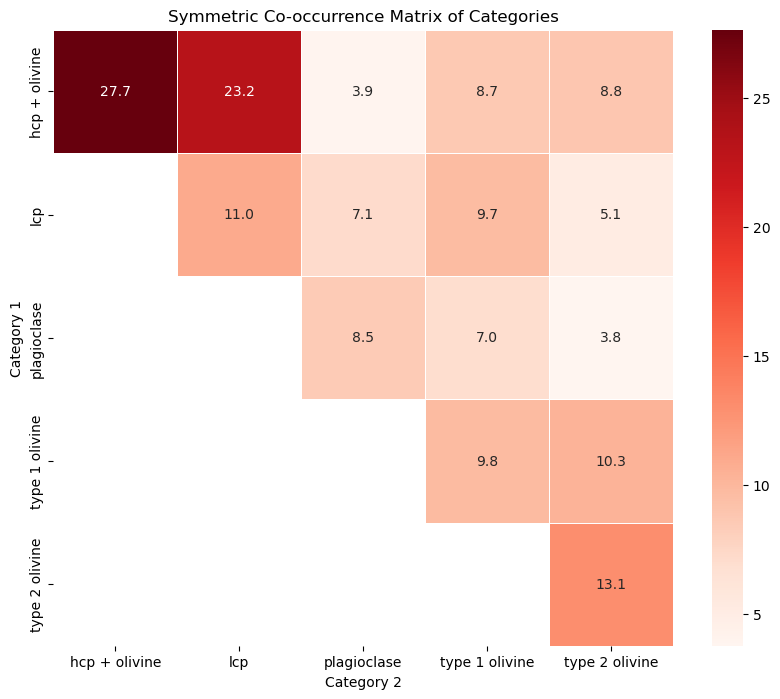

In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Initialize a dictionary to store the co-occurrence counts
co_occurrence = {}

distance_weight = True

# Iterate through the edges of the graph
for node1, node2, data in G.edges(data=True):
    
    category1 = gdf_filtered.loc[node1, "Category"]
    category2 = gdf_filtered.loc[node2, "Category"]

    # Increment co-occurrence counts for each pair of categories
    # if category1 != category2:
    pair = tuple(sorted([category1, category2]))  # Sort the pair to make it symmetric
    if pair not in co_occurrence:
        co_occurrence[pair] = 0
    if distance_weight:
        co_occurrence[pair] += 1 / data["weight"]
    else:
        co_occurrence[pair] += 1

# Convert the dictionary into a pandas DataFrame for easier visualization
category_pairs = list(co_occurrence.keys())
counts = list(co_occurrence.values())

# weight by distance
# counts = [100.0 * float(count)/float(len(G.edges)) for count in counts]

# normalize to max for each category
# Normalize counts for each mineral category
# category_pair_counts = {}
# for pair, count in co_occurrence.items():
#     category1, category2 = pair
#     if category1 not in category_pair_counts:
#         category_pair_counts[category1] = 0
#     if category2 not in category_pair_counts:
#         category_pair_counts[category2] = 0
#     category_pair_counts[category1] += count
#     category_pair_counts[category2] += count

# counts = [
#     float(count) / max(category_pair_counts[pair[0]], category_pair_counts[pair[1]])
#     for pair, count in co_occurrence.items()
# ]

co_occurrence_df = pd.DataFrame(
    {
        "Category 1": [pair[0] for pair in category_pairs],
        "Category 2": [pair[1] for pair in category_pairs],
        "Co-occurrence Count": counts,  # /percent_category_dict[pair[0]]
    }
)

# Pivot the dataframe to create the co-occurrence matrix
co_occurrence_matrix = co_occurrence_df.pivot(
    index="Category 1", columns="Category 2", values="Co-occurrence Count"
).fillna(np.nan)

# Make the matrix symmetric by folding along the diagonal
# co_occurrence_matrix.values = co_occurrence_matrix.values + co_occurrence_matrix.values.T

# Set diagonal values: co-occurrence of each category with itself
# for category in co_occurrence_matrix.index:
#     co_occurrence_matrix.loc[category, category] = co_occurrence_df[co_occurrence_df['Category 1'] == category].shape[0]

# Visualize the symmetric co-occurrence matrix
plt.figure(figsize=(10, 8))
sns.heatmap(co_occurrence_matrix, annot=True, cmap="Reds", fmt=".1f", linewidths=0.5)
plt.title("Symmetric Co-occurrence Matrix of Categories")
plt.show()